In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.transforms as transforms
from torch import nn
import math
import random

In [2]:
transform = transforms.ToTensor()
batch_size = 200


train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transform, 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transform
)
val_data, test_data = torch.utils.data.random_split(test_data, [int(0.9 * len(test_data)), int(0.1 * len(test_data))])
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False, 
                                          num_workers=1),
    'validate' : torch.utils.data.DataLoader(val_data, 
                                          batch_size=batch_size, 
                                          shuffle=False, 
                                          num_workers=1)
}

In [3]:
#get image set with 10 image label each
imageset=np.zeros((10,28,28))
imageset=torch.from_numpy(imageset)
imageset=imageset.float()
complabel=0
while(complabel<10):
  for images,labels in loaders['test']:
    for i in range(labels.size(0)):
      if(labels[i]==complabel):
        imageset[complabel]=images[i].clone()
        complabel+=1

# Comparing PCA and Autoencoders

## PCA: Implementation and reconstruction visualisation

In [4]:
#function for standardizing image
def Standardize(X): 
    mu = np.mean(X, axis = 0) 
    X = X - mu  
    std = np.std(X, axis = 0)  
    std_filled = std.copy()
    std_filled[std == 0] = 1.0
    Xbar = (X-mu) / std_filled  
    return Xbar, mu, std

In [5]:
#function for calculating eigen values and eigen vectors
def eig(S):
    eig_val, eig_vec = np.linalg.eigh(S)  
    sorted_eig  = np.argsort(-eig_val)
    eig_val = eig_val[sorted_eig]
    eig_vec = eig_vec[:, sorted_eig]
    return (eig_val, eig_vec)

In [6]:
#implementing PCA
def PCA(X, num_components):
    #calculate the data covariance matrix S
    S = np.cov(X)  
    #calculate eig values and eig vectors
    eig_vals, eig_vecs = eig(S)
    #select eigen vectors
    U = eig_vecs[:, range(num_components)]
    #to reconstruct, we first compute the projection
    #matrix
    P = U@U.T # projection matrix
    return P

In [7]:
def compute_projection(X,k):
    X = X.detach().numpy()
    Xbar, mu, std = Standardize(X)
    projection = PCA(Xbar.T, k)
    return projection

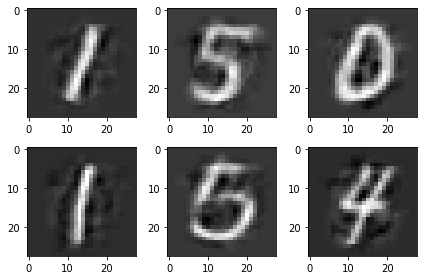

In [8]:
k = 30 #number of components
for itr, (images, labels) in enumerate(loaders['test']):
    image = images.reshape(images.shape[0], -1) #flatten images
    projection = compute_projection(image.T,k)
    image = image.detach().numpy().T
    Xbar, mu, std = Standardize(image)
    output = Xbar@projection
    output = output.reshape(28,28,batch_size)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[:,:,0],cmap='gray')
    ax2.imshow(output[:,:,1],cmap='gray')
    ax3.imshow(output[:,:,2],cmap='gray')
    ax4.imshow(output[:,:,3],cmap='gray')
    ax5.imshow(output[:,:,4],cmap='gray')
    ax6.imshow(output[:,:,5],cmap='gray')
    fig.tight_layout()
    break

## Autoencoder

### Model definition

In [9]:
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,30),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(30,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,784),
        nn.ReLU())
    
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x 

### Training

In [10]:
# AE initializations
epochs = 10
model = AE()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train(no_epochs, model, loss_func, loaders):
    train_loss = list()
    val_loss = list()
    pred_accuracy = list()
    best_val_loss = 1
    for epoch in range(no_epochs):
        total_train_loss = 0
        total_val_loss = 0

        model.train()
        # training
        for itr, (images, labels) in enumerate(loaders['train']):
            
            # Forward pass
            images = images.reshape(-1,784)
            outputs = model(images.float())
            loss = loss_func(outputs, images)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        total_train_loss = total_train_loss / (itr + 1)
        train_loss.append(total_train_loss)
        
        # validation
        model.eval()
        total = 0
        for itr, (images, labels) in enumerate(loaders['validate']):
            images = images.reshape(-1,784)
            outputs = model(images.float())

            loss = loss_func(outputs, images)
            total_val_loss += loss.item()

            pred = torch.nn.functional.softmax(outputs, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy = total / len(val_data)
        pred_accuracy.append(accuracy)

        total_val_loss = total_val_loss / (itr + 1)
        val_loss.append(total_val_loss)

        print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss))

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
            model_state = model.state_dict()

    plt.figure(figsize=(4, 4))
    plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
    plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss Plot")
    plt.legend(loc='upper right')
    return model_state

In [12]:
def evaluate(model, loss_func, loaders):

    model.eval()
    total_test_loss = 0
    total = 0
    
    with torch.no_grad():

        for itr, (images, labels) in enumerate(loaders['test']):
            images = images.reshape(-1,784)
            outputs = model(images.float())

            loss = loss_func(outputs, images)
            total_test_loss += loss.item()

            pred = torch.nn.functional.softmax(outputs, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy = total / len(test_data)
        total_test_loss = total_test_loss / (itr + 1)
        
    return loss, accuracy


Epoch: 1/10, Train Loss: 0.05408907, Val Loss: 0.03346715
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.03346715

Epoch: 2/10, Train Loss: 0.02975160, Val Loss: 0.02612659
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.02612659

Epoch: 3/10, Train Loss: 0.02446097, Val Loss: 0.02260237
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.02260237

Epoch: 4/10, Train Loss: 0.02199433, Val Loss: 0.02064100
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02064100

Epoch: 5/10, Train Loss: 0.02020628, Val Loss: 0.01932137
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.01932137

Epoch: 6/10, Train Loss: 0.01899472, Val Loss: 0.01849526
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.01849526

Epoch: 7/10, Train Loss: 0.01788276, Val Loss: 0.01737667
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.01737667

Epoch: 8/10, Train Loss: 0

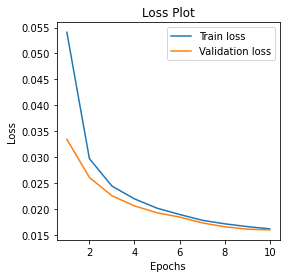

In [13]:
# train and evaluate model
model_state = train(epochs, model, loss_func, loaders)
torch.save(model_state, 'AE.pt')
model.load_state_dict(torch.load('AE.pt'))

test_loss, test_acc = evaluate(model, loss_func, loaders)

print('AE model results')
print(f'Test Loss: {test_loss:.3f}%')

### Reconstruction visualisation

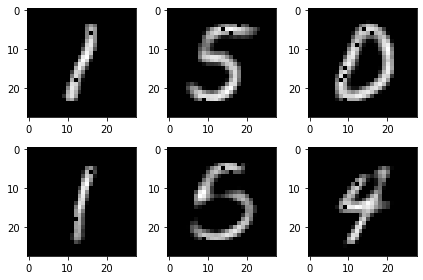

In [14]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

# Experimenting with hidden units of varying sizes

## Model definition

In [15]:
class AE_x(nn.Module):
  def __init__(self,hidsize):
    super(AE_x, self).__init__()
    self.hidsize=hidsize
    self.encoder = nn.Sequential(
        nn.Linear(784,hidsize),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(hidsize,784),
        nn.ReLU())
    
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

## Training and reconstruction visualisation

### Hidden size = 64


Epoch: 1/10, Train Loss: 0.03232032, Val Loss: 0.01621916
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.01621916

Epoch: 2/10, Train Loss: 0.01442780, Val Loss: 0.01268214
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.01268214

Epoch: 3/10, Train Loss: 0.01240985, Val Loss: 0.01159057
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.01159057

Epoch: 4/10, Train Loss: 0.01160351, Val Loss: 0.01105583
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.01105583

Epoch: 5/10, Train Loss: 0.01115701, Val Loss: 0.01072387
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.01072387

Epoch: 6/10, Train Loss: 0.01087598, Val Loss: 0.01052397
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.01052397

Epoch: 7/10, Train Loss: 0.01069338, Val Loss: 0.01040627
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.01040627

Epoch: 8/10, Train Loss: 0

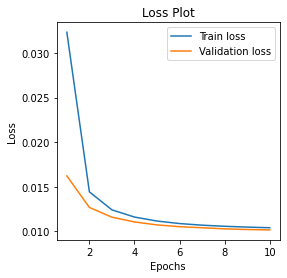

In [16]:
# Experiments on hidden size = 64
model = AE_x(64)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train(epochs, model, loss_func, loaders)
torch.save(model_state, 'AE_64.pt')
model.load_state_dict(torch.load('AE_64.pt'))

test_loss, test_acc = evaluate(model, loss_func, loaders)

print('AE with hidden layer size = 64')
print(f'Test Loss: {test_loss:.3f}%')

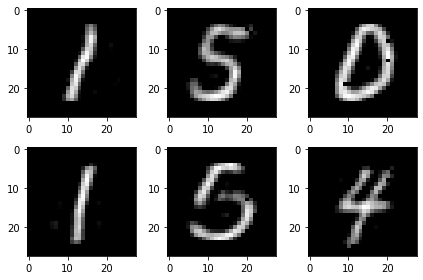

In [17]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

### Hidden size = 128


Epoch: 1/10, Train Loss: 0.02382906, Val Loss: 0.01126040
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.01126040

Epoch: 2/10, Train Loss: 0.00999279, Val Loss: 0.00885473
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.00885473

Epoch: 3/10, Train Loss: 0.00857938, Val Loss: 0.00810194
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.00810194

Epoch: 4/10, Train Loss: 0.00796535, Val Loss: 0.00765706
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.00765706

Epoch: 5/10, Train Loss: 0.00764392, Val Loss: 0.00745174
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.00745174

Epoch: 6/10, Train Loss: 0.00746546, Val Loss: 0.00729962
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.00729962

Epoch: 7/10, Train Loss: 0.00734449, Val Loss: 0.00719674
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.00719674

Epoch: 8/10, Train Loss: 0

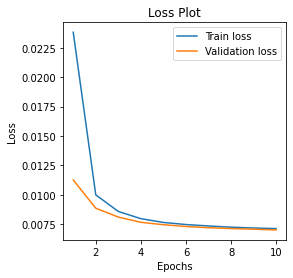

In [18]:
model = AE_x(128)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train(epochs, model, loss_func, loaders)
torch.save(model_state, 'AE_128.pt')
model.load_state_dict(torch.load('AE_128.pt'))

test_loss, test_acc = evaluate(model, loss_func, loaders)

print('AE with hidden layer size = 128')
print(f'Test Loss: {test_loss:.3f}%')

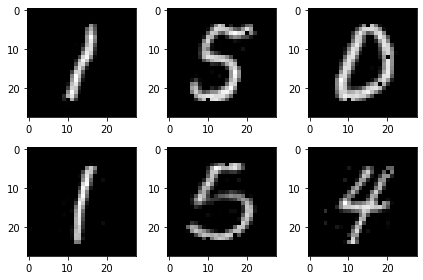

In [19]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

### Hidden size = 256


Epoch: 1/10, Train Loss: 0.01866487, Val Loss: 0.00856984
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.00856984

Epoch: 2/10, Train Loss: 0.00764408, Val Loss: 0.00677048
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.00677048

Epoch: 3/10, Train Loss: 0.00651548, Val Loss: 0.00609346
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.00609346

Epoch: 4/10, Train Loss: 0.00598584, Val Loss: 0.00570942
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.00570942

Epoch: 5/10, Train Loss: 0.00565790, Val Loss: 0.00542882
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.00542882

Epoch: 6/10, Train Loss: 0.00545160, Val Loss: 0.00529532
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.00529532

Epoch: 7/10, Train Loss: 0.00531264, Val Loss: 0.00516408
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.00516408

Epoch: 8/10, Train Loss: 0

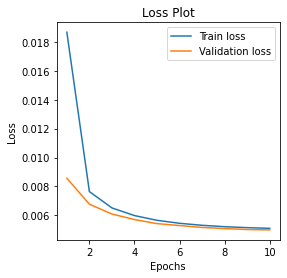

In [20]:
model = AE_x(256)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train(epochs, model, loss_func, loaders)
torch.save(model_state, 'AE_256.pt')
model.load_state_dict(torch.load('AE_256.pt'))

test_loss, test_acc = evaluate(model, loss_func, loaders)

print('AE with hidden layer size = 256')
print(f'Test Loss: {test_loss:.3f}%')

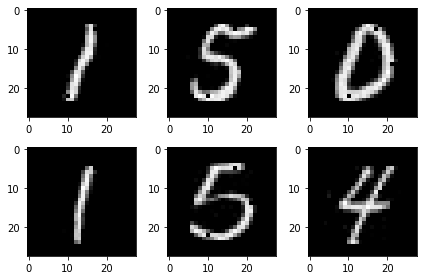

In [21]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

### Noise image

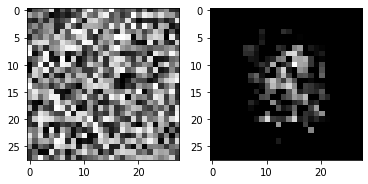

In [22]:
images = np.random.random((1, 784)).astype(np.float32)
images = torch.tensor(images, dtype=torch.float)
output = model(images)
output = output.detach().numpy().reshape(-1,28,28)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(images.reshape(28,28),cmap='gray')
ax2.imshow(output[0],cmap='gray')

# Sparse autoencoders

## Model definition and train functions

In [23]:
class SAE(nn.Module):
  def __init__(self):
    super(SAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,1225),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(1225,784),
        nn.ReLU())
    
  def forward(self,x):
    x=self.encoder(x)
    l1loss=torch.norm(x,p=1)
    x=self.decoder(x)
    return x,l1loss 

In [24]:
def train_SAE(no_epochs, model, loss_func, loaders, lam):
    train_loss = list()
    val_loss = list()
    pred_accuracy = list()
    best_val_loss = 1
    for epoch in range(no_epochs):
        total_train_loss = 0
        total_val_loss = 0

        model.train()
        # training
        for itr, (images, labels) in enumerate(loaders['train']):
            
            # Forward pass
            images = images.reshape(-1,784)
            outputs, l1loss = model(images.float())
            loss = loss_func(outputs, images) + lam*l1loss
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        total_train_loss = total_train_loss / (itr + 1)
        train_loss.append(total_train_loss)
        
        # validation
        model.eval()
        total = 0
        for itr, (images, labels) in enumerate(loaders['validate']):
            images = images.reshape(-1,784)
            outputs, l1loss = model(images.float())
            loss = loss_func(outputs, images) + lam*l1loss
            total_val_loss += loss.item()

            pred = torch.nn.functional.softmax(outputs, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy = total / len(val_data)
        pred_accuracy.append(accuracy)

        total_val_loss = total_val_loss / (itr + 1)
        val_loss.append(total_val_loss)

        print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss))

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
            model_state = model.state_dict()

    plt.figure(figsize=(4, 4))
    plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
    plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss Plot")
    plt.legend(loc='upper right')
    return model_state

In [25]:
def evaluate_SAE(model, loss_func, loaders, lam):

    model.eval()
    total_test_loss = 0
    total = 0
    
    with torch.no_grad():

        for itr, (images, labels) in enumerate(loaders['test']):
            images = images.reshape(-1,784)
            outputs, l1loss = model(images.float())
            loss = loss_func(outputs, images) + lam*l1loss
            total_test_loss += loss.item()

            pred = torch.nn.functional.softmax(outputs, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        accuracy = total / len(test_data)
        total_test_loss = total_test_loss / (itr + 1)
        
    return loss, accuracy

## Training, reconstruction visualisation, average activation

### Ll1 = 1e-4


Epoch: 1/10, Train Loss: 0.10526543, Val Loss: 0.08531345
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.08531345

Epoch: 2/10, Train Loss: 0.08165429, Val Loss: 0.08084103
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.08084103

Epoch: 3/10, Train Loss: 0.08001549, Val Loss: 0.08033699
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.08033699

Epoch: 4/10, Train Loss: 0.07988684, Val Loss: 0.08029310
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.08029310

Epoch: 5/10, Train Loss: 0.07988144, Val Loss: 0.08028978
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.08028978

Epoch: 6/10, Train Loss: 0.07988175, Val Loss: 0.08028959
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.08028959

Epoch: 7/10, Train Loss: 0.07988172, Val Loss: 0.08029617

Epoch: 8/10, Train Loss: 0.07988246, Val Loss: 0.08028735
Saving the model state dictionary for Epoch: 8 w

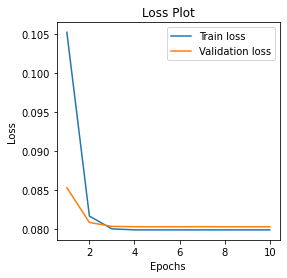

In [26]:
lam = 1e-4
model = SAE()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train_SAE(epochs, model, loss_func, loaders, lam)
torch.save(model_state, 'SAE.pt')
model.load_state_dict(torch.load('SAE.pt'))

test_loss, test_acc = evaluate_SAE(model, loss_func, loaders, lam)

print('SAE')
print(f'Test Loss: {test_loss:.3f}%')

print("Average hidden layer activations for random 10 images")
sum=0
for i in range(10):
    avg=torch.norm(model.encoder(imageset[i].reshape(1,784)),p=1)/256.0
    print(avg.detach().numpy())
    sum+=avg.detach().numpy()
print("Average of these values",sum/10.0)

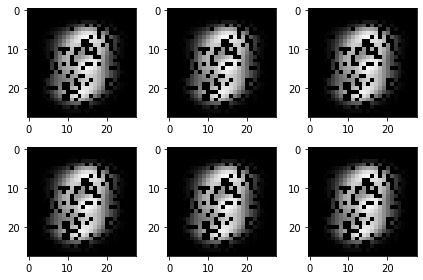

In [27]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output,l1loss = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

### Ll1 = 1e-7


Epoch: 1/10, Train Loss: 0.01440497, Val Loss: 0.00746009
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.00746009

Epoch: 2/10, Train Loss: 0.00653160, Val Loss: 0.00586821
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.00586821

Epoch: 3/10, Train Loss: 0.00553560, Val Loss: 0.00520955
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.00520955

Epoch: 4/10, Train Loss: 0.00503823, Val Loss: 0.00484235
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.00484235

Epoch: 5/10, Train Loss: 0.00476778, Val Loss: 0.00459411
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.00459411

Epoch: 6/10, Train Loss: 0.00455334, Val Loss: 0.00443560
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.00443560

Epoch: 7/10, Train Loss: 0.00441385, Val Loss: 0.00430453
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.00430453

Epoch: 8/10, Train Loss: 0

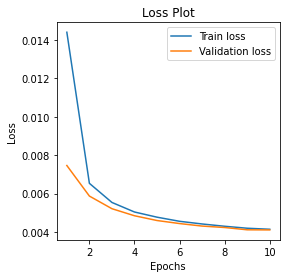

In [28]:
lam = 1e-7
model = SAE()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train_SAE(epochs, model, loss_func, loaders, lam)
torch.save(model_state, 'SAE.pt')
model.load_state_dict(torch.load('SAE.pt'))

test_loss, test_acc = evaluate_SAE(model, loss_func, loaders, lam)

print('SAE')
print(f'Test Loss: {test_loss:.3f}%')

sum = 0
for i in range(10):
    avg=torch.norm(model.encoder(imageset[i].reshape(1,784)),p=1)/256.0
    print(avg.detach().numpy())
    sum+=avg.detach().numpy()
print("Average of these values",sum/10.0)

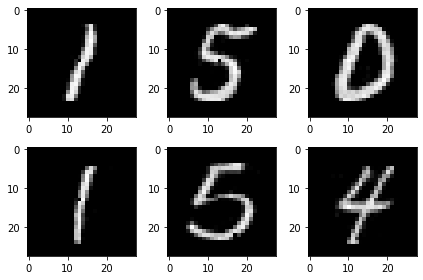

In [29]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output,l1loss = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

#### Learned filter weights

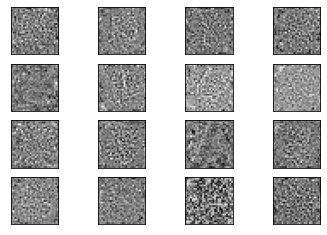

In [30]:
ix=1
fig,ax=plt.subplots()
for i in range(16):
    ax=plt.subplot(4,4,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(model.encoder[0].weight[i].detach().numpy().reshape(28,28),cmap='gray')
    ix+=1

### Ll1 = 1e-10


Epoch: 1/10, Train Loss: 0.01217758, Val Loss: 0.00623362
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.00623362

Epoch: 2/10, Train Loss: 0.00562736, Val Loss: 0.00521313
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.00521313

Epoch: 3/10, Train Loss: 0.00501873, Val Loss: 0.00496377
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.00496377

Epoch: 4/10, Train Loss: 0.00479798, Val Loss: 0.00471605
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.00471605

Epoch: 5/10, Train Loss: 0.00471127, Val Loss: 0.00463341
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.00463341

Epoch: 6/10, Train Loss: 0.00469491, Val Loss: 0.00457035
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.00457035

Epoch: 7/10, Train Loss: 0.00468404, Val Loss: 0.00454252
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.00454252

Epoch: 8/10, Train Loss: 0

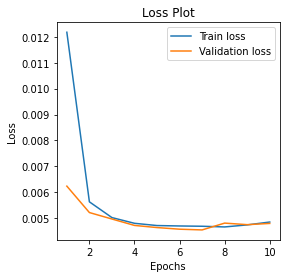

In [31]:
lam = 1e-10
model = SAE()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train_SAE(epochs, model, loss_func, loaders, lam)
torch.save(model_state, 'SAE.pt')
model.load_state_dict(torch.load('SAE.pt'))

test_loss, test_acc = evaluate_SAE(model, loss_func, loaders, lam)

print('SAE')
print(f'Test Loss: {test_loss:.3f}%')

sum = 0
for i in range(10):
    avg=torch.norm(model.encoder(imageset[i].reshape(1,784)),p=1)/256.0
    print(avg.detach().numpy())
    sum+=avg.detach().numpy()
print("Average of these values",sum/10.0)

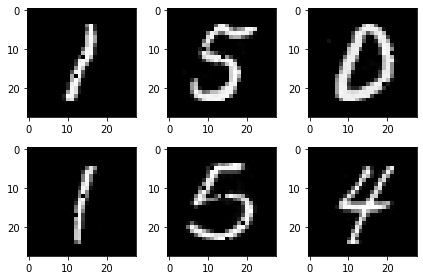

In [32]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output,l1loss = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

### Standard AE: reconstruction, average activation and filter weights

In [33]:
model = AE_x(256)
model.load_state_dict(torch.load('AE_256.pt'))
sum = 0
for i in range(10):
    avg=torch.norm(model.encoder(imageset[i].reshape(1,784)),p=1)/256.0
    print(avg.detach().numpy())
    sum+=avg.detach().numpy()
print("Average of these values",sum/10.0)

0.8476365
0.44866323
0.87702745
0.6128765
0.8592719
0.72487545
0.9427591
0.70593137
0.78175676
1.099273
Average of these values 0.7900071203708648


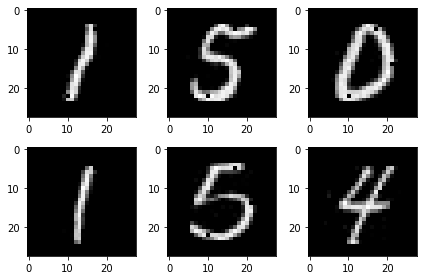

In [34]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

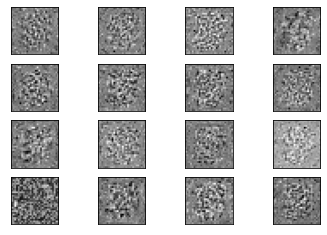

In [35]:
ix=1
fig,ax=plt.subplots()
for i in range(16):
    ax=plt.subplot(4,4,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(model.encoder[0].weight[i].detach().numpy().reshape(28,28),cmap='gray')
    ix+=1

# Denoising Autoencoders

### Standard AE: Results on noisy image, learned filter weights

In [36]:
model.load_state_dict(torch.load('AE_256.pt'))

<All keys matched successfully>

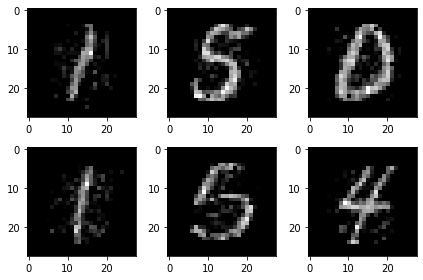

In [37]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    images = images + torch.clip(torch.randn_like(images) * 0.3,0.,1.)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

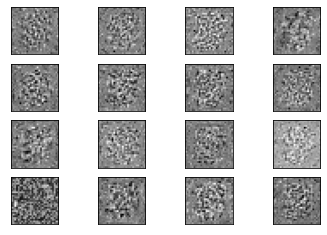

In [38]:
ix=1
fig,ax=plt.subplots()
for i in range(16):
    ax=plt.subplot(4,4,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(model.encoder[0].weight[i].detach().numpy().reshape(28,28),cmap='gray')
    ix+=1

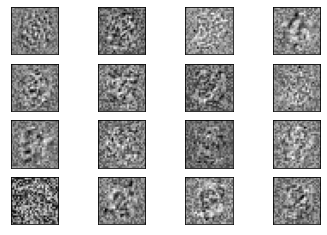

In [39]:
ix=1
fig,ax=plt.subplots()
for i in range(16):
    ax=plt.subplot(4,4,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(model.decoder[0].weight[:,i].detach().numpy().reshape(28,28),cmap='gray')
    ix+=1

### DAE: Model definition

In [40]:
class DAE(nn.Module):
  def __init__(self,noise):
    super(DAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,256),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(256,784),
        nn.ReLU())
    self.noise = noise
    
  def forward(self,x):
    x_ = x + torch.randn_like(x) * self.noise
    x_ = torch.clip(x_,0.,1.)
    x_=self.encoder(x_)
    x_=self.decoder(x_)
    return x_

Training, reconstruction visualisation, learned decoder weights

#### Noise factor = 0.3


Epoch: 1/10, Train Loss: 0.02669187, Val Loss: 0.01565860
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.01565860

Epoch: 2/10, Train Loss: 0.01470162, Val Loss: 0.01364547
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.01364547

Epoch: 3/10, Train Loss: 0.01353915, Val Loss: 0.01317017
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.01317017

Epoch: 4/10, Train Loss: 0.01314202, Val Loss: 0.01283746
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.01283746

Epoch: 5/10, Train Loss: 0.01292795, Val Loss: 0.01274328
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.01274328

Epoch: 6/10, Train Loss: 0.01281292, Val Loss: 0.01265650
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.01265650

Epoch: 7/10, Train Loss: 0.01272666, Val Loss: 0.01256180
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.01256180

Epoch: 8/10, Train Loss: 0

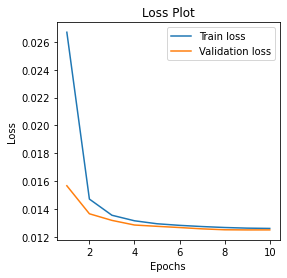

In [41]:
noise_factor = 0.3
model = DAE(noise_factor)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train(epochs, model, loss_func, loaders)
torch.save(model_state, 'DAE_0.3.pt')
model.load_state_dict(torch.load('DAE_0.3.pt'))

test_loss, test_acc = evaluate(model, loss_func, loaders)

print('DAE with noise factor = ',noise_factor)
print(f'Test Loss: {test_loss:.3f}%')

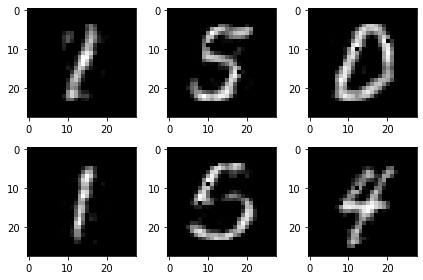

In [42]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

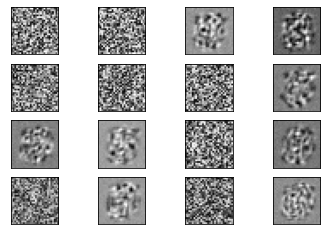

In [43]:
ix=1
fig,ax=plt.subplots()
for i in range(16):
    ax=plt.subplot(4,4,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(model.encoder[0].weight[i].detach().numpy().reshape(28,28),cmap='gray')
    ix+=1

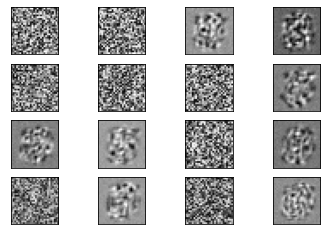

In [44]:
ix=1
fig,ax=plt.subplots()
for i in range(16):
    ax=plt.subplot(4,4,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(model.encoder[0].weight[i].detach().numpy().reshape(28,28),cmap='gray')
    ix+=1

#### Noise factor = 0.5


Epoch: 1/10, Train Loss: 0.03366244, Val Loss: 0.02263773
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.02263773

Epoch: 2/10, Train Loss: 0.02183563, Val Loss: 0.02078038
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.02078038

Epoch: 3/10, Train Loss: 0.02072825, Val Loss: 0.02014695
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.02014695

Epoch: 4/10, Train Loss: 0.02026154, Val Loss: 0.01976066
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.01976066

Epoch: 5/10, Train Loss: 0.01995634, Val Loss: 0.01953405
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.01953405

Epoch: 6/10, Train Loss: 0.01976215, Val Loss: 0.01945415
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.01945415

Epoch: 7/10, Train Loss: 0.01960220, Val Loss: 0.01922793
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.01922793

Epoch: 8/10, Train Loss: 0

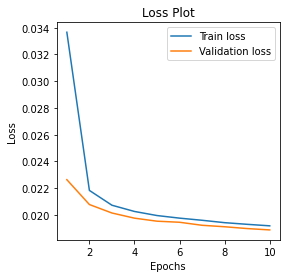

In [45]:
noise_factor = 0.5
model = DAE(noise_factor)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train(epochs, model, loss_func, loaders)
torch.save(model_state, 'DAE_0.5.pt')
model.load_state_dict(torch.load('DAE_0.5.pt'))

test_loss, test_acc = evaluate(model, loss_func, loaders)

print('DAE with noise factor = ',noise_factor)
print(f'Test Loss: {test_loss:.3f}%')

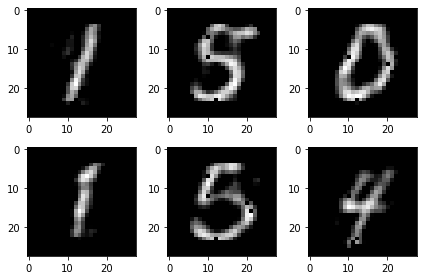

In [46]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

#### Noise factor = 0.8


Epoch: 1/10, Train Loss: 0.04323547, Val Loss: 0.03302477
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.03302477

Epoch: 2/10, Train Loss: 0.03195086, Val Loss: 0.03039708
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03039708

Epoch: 3/10, Train Loss: 0.03034074, Val Loss: 0.02939121
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.02939121

Epoch: 4/10, Train Loss: 0.02952303, Val Loss: 0.02885515
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02885515

Epoch: 5/10, Train Loss: 0.02898893, Val Loss: 0.02852172
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02852172

Epoch: 6/10, Train Loss: 0.02863966, Val Loss: 0.02813355
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.02813355

Epoch: 7/10, Train Loss: 0.02839463, Val Loss: 0.02787875
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.02787875

Epoch: 8/10, Train Loss: 0

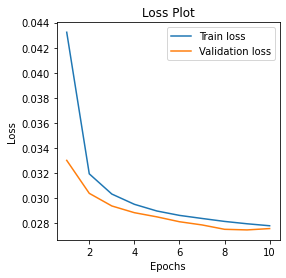

In [47]:
noise_factor = 0.8
model = DAE(noise_factor)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train(epochs, model, loss_func, loaders)
torch.save(model_state, 'DAE_0.8.pt')
model.load_state_dict(torch.load('DAE_0.8.pt'))

test_loss, test_acc = evaluate(model, loss_func, loaders)

print('DAE with noise factor = ',noise_factor)
print(f'Test Loss: {test_loss:.3f}%')

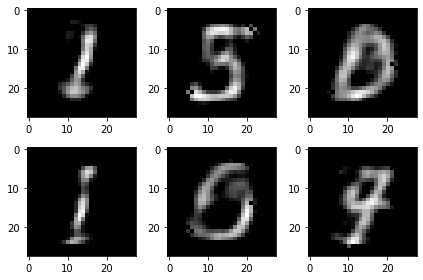

In [48]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

#### Noise factor = 0.9


Epoch: 1/10, Train Loss: 0.04668936, Val Loss: 0.03637553
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.03637553

Epoch: 2/10, Train Loss: 0.03523245, Val Loss: 0.03370456
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03370456

Epoch: 3/10, Train Loss: 0.03348647, Val Loss: 0.03251853
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03251853

Epoch: 4/10, Train Loss: 0.03262801, Val Loss: 0.03191420
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.03191420

Epoch: 5/10, Train Loss: 0.03206589, Val Loss: 0.03161474
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.03161474

Epoch: 6/10, Train Loss: 0.03169260, Val Loss: 0.03116177
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.03116177

Epoch: 7/10, Train Loss: 0.03147703, Val Loss: 0.03091469
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.03091469

Epoch: 8/10, Train Loss: 0

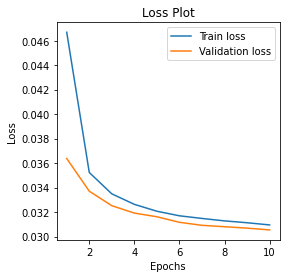

In [49]:
noise_factor = 0.9
model = DAE(noise_factor)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model_state = train(epochs, model, loss_func, loaders)
torch.save(model_state, 'DAE_0.9.pt')
model.load_state_dict(torch.load('DAE_0.9.pt'))

test_loss, test_acc = evaluate(model, loss_func, loaders)

print('DAE with noise factor = ',noise_factor)
print(f'Test Loss: {test_loss:.3f}%')

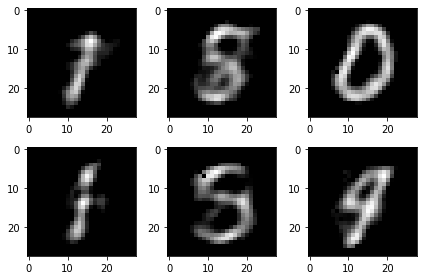

In [50]:
for itr, (images, labels) in enumerate(loaders['test']):
    images = images.reshape(-1,784)
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

# Convolutional autoencoders

### Training functions

In [51]:
def train_convAE(no_epochs, model, loss_func, loaders):
    train_loss = list()
    val_loss = list()
    pred_accuracy = list()
    best_val_loss = 1
    for epoch in range(no_epochs):
        total_train_loss = 0
        total_val_loss = 0

        model.train()
        # training
        for itr, (images, labels) in enumerate(loaders['train']):
            
            # Forward pass
            outputs = model(images.float())
            loss = loss_func(outputs, images)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        total_train_loss = total_train_loss / (itr + 1)
        train_loss.append(total_train_loss)
        
        # validation
        model.eval()
        total = 0
        for itr, (images, labels) in enumerate(loaders['validate']):
            outputs = model(images.float())

            loss = loss_func(outputs, images)
            total_val_loss += loss.item()


        total_val_loss = total_val_loss / (itr + 1)
        val_loss.append(total_val_loss)

        print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss))

        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
            model_state = model.state_dict()

    plt.figure(figsize=(4, 4))
    plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
    plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss Plot")
    plt.legend(loc='upper right')
    return model_state

In [52]:
def evaluate_convAE(model, loss_func, loaders):

    model.eval()
    total_test_loss = 0
    total = 0
    
    with torch.no_grad():

        for itr, (images, labels) in enumerate(loaders['test']):
            outputs = model(images.float())

            loss = loss_func(outputs, images)
            total_test_loss += loss.item()

        total_test_loss = total_test_loss / (itr + 1)
        
    return loss

### Decoder: upsample only by unpool

In [53]:
class conv_AE_unpool(nn.Module): #define unpooling outside the decoder and separately in forward nn.Sequential just takes one input
    
    def __init__(self): #class constructor
        super(conv_AE_unpool,self).__init__() #calls the parent constructor
        
        #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) # 28x28x1 to 14x14x8
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) #14x14x8 to 7x7x16
        self.encoder_conv3 = nn.Sequential(nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) #7x7x16 to 3x3x16
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.Identity()) #7x7x16 to 7x7x16
        self.decoder_conv2 = nn.Sequential(nn.Conv2d(16,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU()) #14x14x16 to 14x14x8
        self.decoder_conv3 = nn.Sequential(nn.Conv2d(8,1, kernel_size = 3, stride = 1,padding= 1),nn.ReLU()) #28x28x8 to 28x28x1
        
        #defining the unpooling operation
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())  # 28x28x1 to 14x14x8
        encoded_input,indices2  = self.encoder_conv2(encoded_input) #14x14x8 to 7x7x16
        encoded_input,indices3  = self.encoder_conv3(encoded_input) #7x7x16 to 3x3x16
        
        
        reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7])) #3x3x16 to 7x7x16
        reconstructed_input     = self.decoder_conv1(reconstructed_input) #7x7x16 to 7x7x16
        reconstructed_input     = self.unpool(reconstructed_input,indices2) #7x7x16 to 14x14x16
        reconstructed_input     = self.decoder_conv2(reconstructed_input)#14x14x16 to 14x14x8
        reconstructed_input     = self.unpool(reconstructed_input,indices1)#14x14x8 to 28x28x8
        reconstructed_input     = self.decoder_conv3(reconstructed_input)#28x28x8 to 28x28x1

        
        return reconstructed_input


Epoch: 1/10, Train Loss: 0.08146941, Val Loss: 0.05784879
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.05784879

Epoch: 2/10, Train Loss: 0.04745516, Val Loss: 0.03985545
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03985545

Epoch: 3/10, Train Loss: 0.03340785, Val Loss: 0.02897443
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.02897443

Epoch: 4/10, Train Loss: 0.02605863, Val Loss: 0.02368008
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02368008

Epoch: 5/10, Train Loss: 0.02123185, Val Loss: 0.01911809
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.01911809

Epoch: 6/10, Train Loss: 0.01751559, Val Loss: 0.01608907
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.01608907

Epoch: 7/10, Train Loss: 0.01511572, Val Loss: 0.01416826
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.01416826

Epoch: 8/10, Train Loss: 0

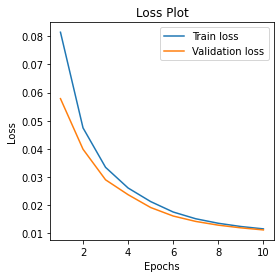

In [54]:
model = conv_AE_unpool()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model_state = train_convAE(epochs, model, loss_func, loaders)
torch.save(model_state, 'ConvAE_unpool.dth')
model.load_state_dict(torch.load('ConvAE_unpool.dth'))

test_loss = evaluate_convAE(model, loss_func, loaders)

print('Convolutional AE: Decoding by unpooling')
print(f'Test Loss: {test_loss:.3f}%')

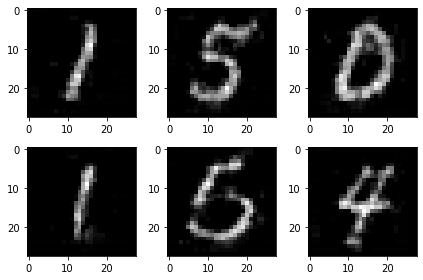

In [55]:
for itr, (images, labels) in enumerate(loaders['test']):
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

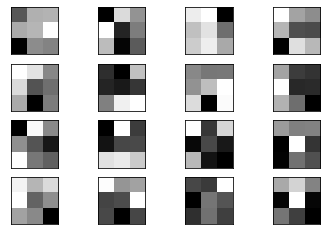

In [56]:
ix=1
fig,ax=plt.subplots()
for i in range(16):
    ax=plt.subplot(4,4,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(model.decoder_conv2[0].weight[0,i,:,:].detach().numpy().reshape(3,3),cmap='gray')
    ix+=1

### Decoder: upsample only by deconvolving

In [57]:
class conv_AE_deconv(nn.Module):
    def __init__(self): #class constructor
        super(conv_AE_deconv,self).__init__() #calls the parent constructor
        
        #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
        self.encoder_conv3 = nn.Sequential(nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),nn.ReLU())
        self.decoder_conv2 = nn.Sequential(nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),nn.ReLU())
        self.decoder_conv3 = nn.Sequential(nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),nn.ReLU())
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input  = self.encoder_conv1(x.float())
        encoded_input  = self.encoder_conv2(encoded_input)
        encoded_input  = self.encoder_conv3(encoded_input)

        reconstructed_input     = self.decoder_conv1(encoded_input)
        reconstructed_input     = self.decoder_conv2(reconstructed_input)
        reconstructed_input     = self.decoder_conv3(reconstructed_input)

        return reconstructed_input


Epoch: 1/10, Train Loss: 0.08313170, Val Loss: 0.06114338
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.06114338

Epoch: 2/10, Train Loss: 0.04864719, Val Loss: 0.03968785
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03968785

Epoch: 3/10, Train Loss: 0.03592064, Val Loss: 0.03246369
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03246369

Epoch: 4/10, Train Loss: 0.03061918, Val Loss: 0.02837561
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02837561

Epoch: 5/10, Train Loss: 0.02689574, Val Loss: 0.02383384
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.02383384

Epoch: 6/10, Train Loss: 0.02296005, Val Loss: 0.02146911
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.02146911

Epoch: 7/10, Train Loss: 0.02094026, Val Loss: 0.01981629
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.01981629

Epoch: 8/10, Train Loss: 0

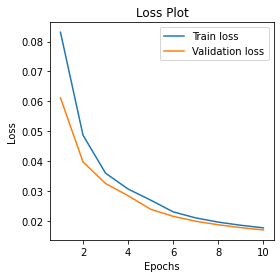

In [58]:
model = conv_AE_deconv()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model_state = train_convAE(epochs, model, loss_func, loaders)
torch.save(model_state, 'ConvAE_deconv.dth')
model.load_state_dict(torch.load('ConvAE_deconv.dth'))

test_loss = evaluate_convAE(model, loss_func, loaders)

print('Convolutional AE: Decoding by deconvolution')
print(f'Test Loss: {test_loss:.3f}%')

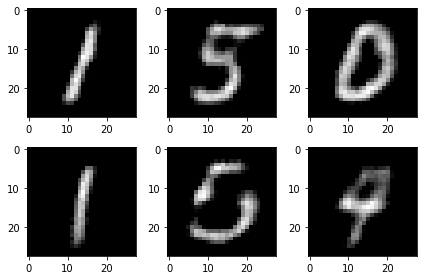

In [59]:
for itr, (images, labels) in enumerate(loaders['test']):
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

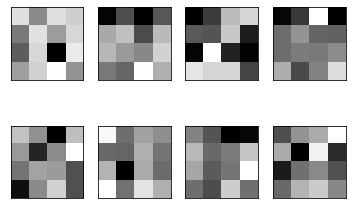

In [60]:
ix=1
fig,ax=plt.subplots()
for i in range(8):
    ax=plt.subplot(2,4,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(model.decoder_conv2[0].weight[0,i,:,:].detach().numpy().reshape(4,4),cmap='gray')
    ix+=1

### Decoder: upsample by unpool and deconvolving

In [61]:
class conv_AE_deconv_unpool(nn.Module):
    def __init__(self): #class constructor
        super(conv_AE_deconv_unpool,self).__init__() #calls the parent constructor
        
         #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
        self.encoder_conv3 = nn.Sequential(nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
        self.decoder_conv2 = nn.Sequential(nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
        self.decoder_conv3 = nn.Sequential(nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
        
        #defining the unpooling operation
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())
        encoded_input,indices2  = self.encoder_conv2(encoded_input)
        encoded_input,indices3  = self.encoder_conv3(encoded_input)
        
        
        reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7]))
        reconstructed_input     = self.decoder_conv1(reconstructed_input)
        reconstructed_input     = self.unpool(reconstructed_input,indices2)
        reconstructed_input     = self.decoder_conv2(reconstructed_input)
        reconstructed_input     = self.unpool(reconstructed_input,indices1)
        reconstructed_input     = self.decoder_conv3(reconstructed_input)
        
        
        return reconstructed_input


Epoch: 1/10, Train Loss: 0.07917652, Val Loss: 0.05579346
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.05579346

Epoch: 2/10, Train Loss: 0.04407337, Val Loss: 0.03443019
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03443019

Epoch: 3/10, Train Loss: 0.02847877, Val Loss: 0.02429396
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.02429396

Epoch: 4/10, Train Loss: 0.02161339, Val Loss: 0.01953368
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.01953368

Epoch: 5/10, Train Loss: 0.01789357, Val Loss: 0.01649019
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.01649019

Epoch: 6/10, Train Loss: 0.01523623, Val Loss: 0.01417638
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.01417638

Epoch: 7/10, Train Loss: 0.01319627, Val Loss: 0.01234486
Saving the model state dictionary for Epoch: 7 with Validation loss: 0.01234486

Epoch: 8/10, Train Loss: 0

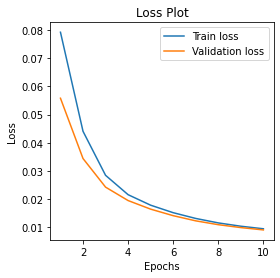

In [62]:
model = conv_AE_deconv_unpool()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model_state = train_convAE(epochs, model, loss_func, loaders)
torch.save(model_state, 'ConvAE_deconvunpool.dth')
model.load_state_dict(torch.load('ConvAE_deconvunpool.dth'))

test_loss = evaluate_convAE(model, loss_func, loaders)

print('Convolutional AE: Decoding by deconvolution and unpooling')
print(f'Test Loss: {test_loss:.3f}%')

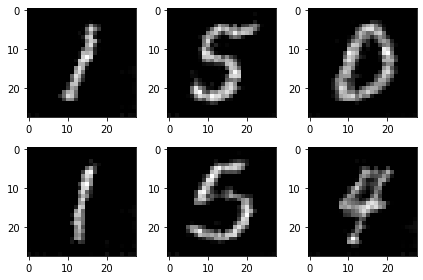

In [63]:
for itr, (images, labels) in enumerate(loaders['test']):
    output = model(images.float())
    output = output.detach().numpy().reshape(-1,28,28)
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
    ax1.imshow(output[0],cmap='gray')
    ax2.imshow(output[1],cmap='gray')
    ax3.imshow(output[2],cmap='gray')
    ax4.imshow(output[3],cmap='gray')
    ax5.imshow(output[4],cmap='gray')
    ax6.imshow(output[5],cmap='gray')
    fig.tight_layout()
    break

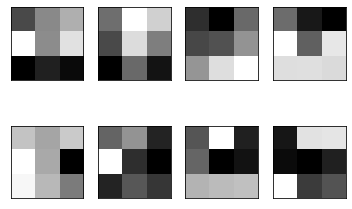

In [64]:
ix=1
fig,ax=plt.subplots()
for i in range(8):
    ax=plt.subplot(2,4,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(model.decoder_conv2[0].weight[0,i,:,:].detach().numpy().reshape(3,3),cmap='gray')
    ix+=1